In [1]:
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd

from sklearn import cluster
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import silhouette_score
from sklearn import model_selection
from sklearn import compose
from sklearn import pipeline
from sklearn import base

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [2]:
STOPWORDS = list(set(stopwords.words('italian')))

In [3]:
to_remove = ["junior", "senior", "stage", "sr", "entwickler", "time", "remote"]
STOPWORDS.extend(to_remove)

In [4]:
def sanitize_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces

    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords

    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in STOPWORDS]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [7]:
with open("./sample_jobs.txt", "r", encoding="utf-8") as f:
    jobs = f.read().splitlines()

In [8]:
def normalize_role(text):
    roles_to_normalize = [("front end", "frontend"), ("back end", "backend")]
    for wrong, right in roles_to_normalize:
        if wrong in text:
            return right + " " + text[len(wrong) + 1:]
        else:
            return text

In [9]:
cleaned_jobs = [sanitize_text(job, remove_stopwords=True) for job in jobs]
cleaned_roles = [normalize_role(job) for job in cleaned_jobs]

In [10]:
def find_elbow(X):
    range_n_clusters = range(2, 20)         # clusters range you want to select
    best_clusters = 0                       # best cluster number which you will get
    previous_silh_avg = 0.0

    for n_clusters in tqdm(range_n_clusters, desc="Finding clusters..."):
        clusterer = cluster.KMeans(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        if silhouette_avg > previous_silh_avg:
            previous_silh_avg = silhouette_avg
            best_clusters = n_clusters
    return (silhouette_avg, best_clusters)

Finding clusters...: 100%|██████████| 18/18 [00:00<00:00, 34.31it/s]


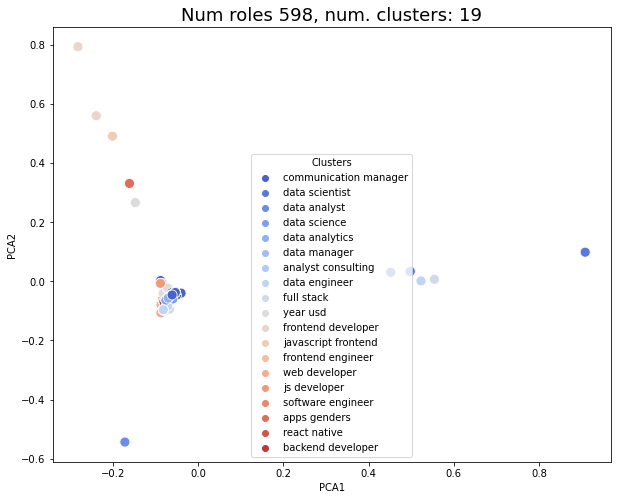

In [23]:
def run(vectorizer, cleaned_jobs):
    X = vectorizer.fit_transform(cleaned_jobs).toarray()
    voc = vectorizer.get_feature_names()

    sil_score, opt_n_clusters = find_elbow(X)
    # print(f"Found number of optimal clusters: {opt_n_clusters}")

    clusterer = cluster.KMeans(n_clusters=opt_n_clusters, random_state=42).fit(X)
    clusters = clusterer.predict(X)

    decomposer = decomposition.PCA(n_components=2, random_state=42)
    reduced = decomposer.fit_transform(X)

    centers = decomposer.transform(clusterer.cluster_centers_)

    component_1, component_2 = reduced[:, 0], reduced[:, 1]
    df = pd.concat([pd.Series(component_1, name="PCA1"), \
        pd.Series(component_2, name="PCA2"), \
            pd.Series(clusters, name="cluster")], axis=1)

    
    # print("Top terms per cluster:")
    order_centroids = clusterer.cluster_centers_.argsort()[:, ::-1]
    kws = []
    for i, (_x, _y) in enumerate(centers):
        # print("Cluster %d:" % i),
        for ind in order_centroids[i, :1]:
            # print(' %s' % voc[ind])
            kws.append(voc[ind])
            # plt.text(_x, _y, f"{i}_{voc[ind]}", horizontalalignment='left', size='medium', color='black')
    
    df['cluster'] = df['cluster'].map({key:value for (key, value) in enumerate(kws)})

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="cluster", palette="coolwarm", s=100)
    plt.title(f"Num roles {len(cleaned_roles)}, num. clusters: {opt_n_clusters}", fontsize=18)
    plt.legend(fontsize=10, title="Clusters")
    plt.show()

    df['input'] = cleaned_roles

    return df[["input", "cluster"]]

df = run(TfidfVectorizer(ngram_range=(2, 2), max_features=50, smooth_idf=True, sublinear_tf=True), cleaned_roles)

In [24]:
df

,PCA1,PCA2,cluster,input
0,-0.053018,-0.037678,communication manager,ocm communication consultant life sciences m w
1,-0.053018,-0.037678,communication manager,ocm communication consultant life sciences m w
2,-0.053018,-0.037678,communication manager,technicien en audiovisuel au service de commun...
3,-0.053018,-0.037678,communication manager,esg issuer communication associate
4,-0.053018,-0.037678,communication manager,adjoint reporting projets de recherche
...,...,...,...,...
593,-0.075113,-0.063694,data science,computer vision data science engineer
594,-0.069703,-0.056807,data analytics,product manager data analytics and
595,0.908076,0.098738,data scientist,data scientist ar vr product xr analytics
596,-0.060534,-0.046086,communication manager,associate director manager data operation


In [17]:
main = pd.DataFrame(jobs, columns=["item"])

In [18]:
main

,item
0,Senior OCM & Communication Consultant Life Sci...
1,Senior OCM & Communication Consultant Life Sci...
2,Technicien-ne en Audiovisuel au Service de Com...
3,ESG Issuer Communication Senior Associate
4,Adjoint·e reporting projets de recherche
...,...
593,Senior Computer Vision / AI / Data Science Eng...
594,Junior Product Manager Data Analytics and AI
595,"Data Scientist, AR/VR Product (XR Analytics)"
596,Associate Director/Manager Data Operation


In [19]:
df = run(TfidfVectorizer(ngram_range=(2, 2), max_features=50, smooth_idf=True, sublinear_tf=True), main.item.values)

Finding clusters...: 100%|██████████| 18/18 [00:00<00:00, 37.51it/s]


In [20]:
df

{'silhouette': 0.6490594154449665, 'clusters': 19}

In [11]:
# todo: remove "full time" and other temporal indicators
# find ideal number of clusters automatically 
# todo: do gridsearch, try these metrics:
#@ https://stackoverflow.com/questions/44066264/how-to-choose-parameters-in-tfidfvectorizer-in-sklearn-during-unsupervised-clust
# Calinski-Harabasz Index
# Davies-Bouldin Index
# https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

In [13]:
vec = TfidfVectorizer(ngram_range=(2, 3), smooth_idf=True, sublinear_tf=True)

In [16]:
m = vec.fit_transform(cleaned_roles).todense()

In [29]:
m

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])